In [1]:
import torch
torch.__version__

'2.5.1+cu124'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [21]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import AdamW
import os
from tqdm import tqdm
from sklearn.metrics import f1_score

## Load Data

In [4]:
class FERDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

        # Ekstrak label dan piksel
        self.labels = self.dataframe['emotion'].values
        self.pixels = self.dataframe['pixels'].apply(self.string_to_image).values

    def string_to_image(self, pixels_string):
        # Konversi string piksel menjadi numpy array dan reshape ke 48x48
        pixels = np.array(pixels_string.split(), dtype='float32')
        image = pixels.reshape(48, 48)
        image = np.expand_dims(image, axis=-1)  # Tambahkan channel dimensi
        return image

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image = self.pixels[idx]
        label = self.labels[idx]
        
        image = Image.fromarray(image.squeeze().astype('uint8'), mode='L')

        # Jika ada transformasi, terapkan ke image
        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
# Create image size
IMG_SIZE = 224

# Create transform pipeline manually
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),  # Randomly flip horizontally
    transforms.RandomRotation(10),     # Randomly rotate by +/- 10 degrees
    transforms.RandomResizedCrop(224), # Randomly crop and resize to 224x224
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust color
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
]) 

# Create transform pipeline manually
test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

 
print(f"train transforms: {train_transforms}")
print(f"test transforms: {test_transforms}")

train transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
    ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.1, 0.1))
    ToTensor()
    Normalize(mean=[0.5], std=[0.5])
)
test transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.5], std=[0.5])
)


In [6]:
data = pd.read_csv('../Data/fer2013_clean.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33325 entries, 0 to 33324
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   pixels   33325 non-null  object
 1   emotion  33325 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 520.8+ KB


In [7]:
# Pertama, pisahkan data train (90%) dan validation (10%)
data_train, data_test = train_test_split(data, test_size=0.1, stratify=data['emotion'], random_state=123)
data_train, data_val = train_test_split(data_train, test_size=0.1, stratify=data_train['emotion'], random_state=123)

# Cek ukuran masing-masing set untuk memastikan proporsi
print(f'Train set size: {len(data_train)}')
print(f'Validation set size: {len(data_val)}')
print(f'Test set size: {len(data_test)}')

Train set size: 26992
Validation set size: 3000
Test set size: 3333


In [8]:
train_dataset = FERDataset(data_train, transform=train_transforms)
val_dataset = FERDataset(data_val, transform=test_transforms)
test_dataset = FERDataset(data_test, transform=test_transforms)
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [9]:
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Mapping dari label ke ID (label2id)
label2id = {c: idx for idx, c in enumerate(labels)}

# Mapping dari ID ke label (id2label)
id2label = {idx: c for idx, c in enumerate(labels)}

print("label2id:", label2id)
print("id2label:", id2label)

label2id: {'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Sad': 4, 'Surprise': 5, 'Neutral': 6}
id2label: {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}


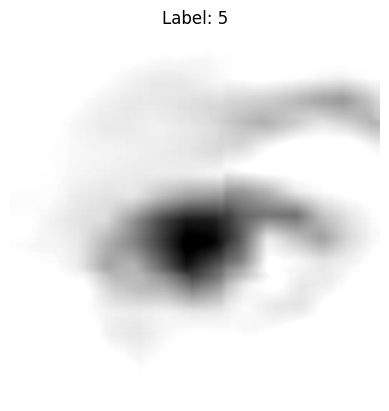

In [10]:
# Ambil satu contoh dari train_dataset
image, label = train_dataset[0]  # Index pertama dataset

# Jika transform menghasilkan tensor, konversi ke format numpy
if isinstance(image, torch.Tensor):
    image = image.permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)

# Plot gambar
plt.imshow(image, cmap='gray')  # Gunakan cmap='gray' jika gambar grayscale
plt.title(f"Label: {label}")
plt.axis('off')  # Hilangkan sumbu
plt.show()

In [11]:
image, label = train_dataset[0]
image.shape

torch.Size([1, 224, 224])

## Build Vision Transformer (ViT) Model

In [12]:
from torch import nn

In [13]:
class PatchEmbedding(nn.Module):
    def __init__(self, 
                 in_channels:int=1,
                 patch_size:int=16,
                 embedding_dim:int=768
                ):
        super().__init__()
        
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)
    def forward(self, x):
        image_resolution = x.shape[-1]
        
        x_patched = self.patcher(x) # (n_samples, embed_dim, n_patches ** 0.5, n_patches ** 0.5)
        x_flattened = x_patched.flatten(2) # (n_samples, embed_dim, n_patches)
        x = x_flattened.transpose(1, 2) # (n_samples, n_patches, embed_dim)
        
        return x

In [14]:
class MultiheadSelfAttentionBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 attn_dropout:float=0.):
        super().__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True)
    def forward(self, x):
        attn_output, _ = self.multihead_attn(query=x,
                                             key=x,
                                             value=x,
                                             need_weights=False)
        return attn_output

In [15]:
class MLPBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 dropout:float=0.):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )
    def forward(self, x):
        x = self.mlp(x)
        return x

In [16]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 mlp_size:int=3072,
                 mlp_dropout:float=0.,
                 attn_dropout:float=0.):
        super().__init__()
        self.layer_norm1 = nn.LayerNorm(normalized_shape=embedding_dim, eps=1e-6)
        
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        
        self.layer_norm2 = nn.LayerNorm(normalized_shape=embedding_dim, eps=1e-6)
        
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)
    def forward(self, x):
        x = self.msa_block(self.layer_norm1(x)) + x 
        
        x = self.mlp_block(self.layer_norm2(x)) + x 
        
        return x

In [17]:
class ViT(nn.Module):
    def __init__(self,
                 img_size:int=224,
                 in_channels:int=3,
                 patch_size:int=16,
                 num_transformer_layers:int=12,
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 num_heads:int=12,
                 attn_dropout:float=0.,
                 mlp_dropout:float=0.,
                 embedding_dropout:float=0.,
                 num_classes:int=1000):
        super().__init__()
        self.num_patches = (img_size * img_size) // patch_size**2

        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
                 
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
                
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
       
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim, eps=1e-6),
            nn.Linear(in_features=embedding_dim, 
                      out_features=num_classes)
        )
    
    def forward(self, pixel_values, labels=None):
        batch_size = pixel_values.shape[0]

        x = self.patch_embedding(pixel_values) # (n_samples, num_patches, embed_dim)
        
        class_token = self.class_embedding.expand(batch_size, -1, -1) # (n_samples, 1, embed_dim)

        x = torch.cat((class_token, x), dim=1) # (n_samples, 1 + n_patches, embed_dim)

        x = self.position_embedding + x # add position embed

        x = self.embedding_dropout(x)

        x = self.transformer_encoder(x)

        logits = self.classifier(x[:, 0])

        # Jika labels diberikan, hitung loss
        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)
    
        return (loss, logits) if loss is not None else logits

## Model Training

In [18]:
model = ViT(num_classes=len(class_names), in_channels=1, patch_size=32, num_heads=8, embedding_dim=512)

In [19]:
from torchinfo import summary

summary(
    model=model,
    input_size=(1, 1, 224, 224),  # (batch_size, in_channels, img_size, img_size)
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=15,
    row_settings=["var_names"],
)

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
ViT (ViT)                                                    [1, 1, 224, 224] [1, 7]          26,112          True
├─PatchEmbedding (patch_embedding)                           [1, 1, 224, 224] [1, 49, 512]    --              True
│    └─Conv2d (patcher)                                      [1, 1, 224, 224] [1, 512, 7, 7]  524,800         True
├─Dropout (embedding_dropout)                                [1, 50, 512]    [1, 50, 512]    --              --
├─Sequential (transformer_encoder)                           [1, 50, 512]    [1, 50, 512]    --              True
│    └─TransformerEncoderBlock (0)                           [1, 50, 512]    [1, 50, 512]    --              True
│    │    └─LayerNorm (layer_norm1)                          [1, 50, 512]    [1, 50, 512]    1,024           True
│    │    └─MultiheadSelfAttentionBlock (msa_block)          [1, 50, 512]    [1, 5

In [20]:
EPOCHS = 1000
LEARNING_RATE = 3e-5
NUM_CLASSES = 7
SEED = 123
BATCH_SIZE = 64
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=torch.Generator().manual_seed(SEED))
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=torch.Generator().manual_seed(SEED))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, generator=torch.Generator().manual_seed(SEED))

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

# Define the learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# Define path
SAVE_PATH = "../Hasil Eksperimen"
os.makedirs(SAVE_PATH, exist_ok=True)

# Initialize lists to store training and validation metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Initialize the best metric for model saving
best_val_accuracy = -float('inf')

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    # Training
    pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{EPOCHS}")
    for batch_idx, (inputs, targets) in enumerate(pbar):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update statistics
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        # Update progress bar
        pbar.set_postfix({
            "Loss": f"{train_loss / (batch_idx + 1):.4f}",
            "Acc": f"{correct / total:.4f}"
        })

    # Calculate training accuracy and loss
    train_accuracy = correct / total
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Print training summary
    print(f"Epoch {epoch + 1}/{EPOCHS}: "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Train Acc: {train_accuracy:.4f}")

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    all_targets = []
    all_predicted = []

    with torch.no_grad():  # Disable gradient computation
        pbar = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{EPOCHS} (Validation)")
        for batch_idx, (inputs, targets) in enumerate(pbar):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Update statistics
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += targets.size(0)
            val_correct += predicted.eq(targets).sum().item()

            # Collect all targets and predictions for F1-score
            all_targets.extend(targets.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())

            # Update progress bar
            pbar.set_postfix({
                "Loss": f"{val_loss / (batch_idx + 1):.4f}",
                "Acc": f"{val_correct / val_total:.4f}"
            })

    # Calculate validation accuracy, loss, and F1-score
    val_accuracy = val_correct / val_total
    avg_val_loss = val_loss / len(val_loader)
    val_f1 = f1_score(all_targets, all_predicted, average="weighted")
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    # Print validation summary
    print(f"Epoch {epoch + 1}/{EPOCHS}: "
          f"Val Loss: {avg_val_loss:.4f}, "
          f"Val Acc: {val_accuracy:.4f}, "
          f"Val F1: {val_f1:.4f}")

    # Step the learning rate scheduler based on validation loss
    scheduler.step(avg_val_loss)

    # Print the current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Current Learning Rate: {current_lr}")

    # Save the best model based on validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        model_path = os.path.join(SAVE_PATH, "aug.pt")
        torch.save(model.state_dict(), model_path)
        print(f"Best model saved at {model_path} with val accuracy: {best_val_accuracy:.4f}")

    # Save loss and accuracy plots
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss", marker='o')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", marker='o')
    plt.title("Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    loss_plot_path = os.path.join(SAVE_PATH, "aug_loss.png")
    plt.savefig(loss_plot_path)
    plt.close()

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Training Accuracy", marker='o')
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Validation Accuracy", marker='o')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    accuracy_plot_path = os.path.join(SAVE_PATH, "aug_acc.png")
    plt.savefig(accuracy_plot_path)
    plt.close()

Epoch 1/1000: 100%|██████████| 422/422 [07:13<00:00,  1.03s/it, Loss=1.7957, Acc=0.2484]


Epoch 1/1000: Train Loss: 1.7957, Train Acc: 0.2484


Epoch 1/1000 (Validation): 100%|██████████| 47/47 [00:16<00:00,  2.77it/s, Loss=1.8065, Acc=0.2453]


Epoch 1/1000: Val Loss: 1.8065, Val Acc: 0.2453, Val F1: 0.1969
Current Learning Rate: 3e-05
Best model saved at ../Hasil Eksperimen/aug.pt with val accuracy: 0.2453


Epoch 2/1000: 100%|██████████| 422/422 [07:21<00:00,  1.05s/it, Loss=1.7706, Acc=0.2663]


Epoch 2/1000: Train Loss: 1.7706, Train Acc: 0.2663


Epoch 2/1000 (Validation): 100%|██████████| 47/47 [00:16<00:00,  2.83it/s, Loss=1.7428, Acc=0.2897]


Epoch 2/1000: Val Loss: 1.7428, Val Acc: 0.2897, Val F1: 0.1936
Current Learning Rate: 3e-05
Best model saved at ../Hasil Eksperimen/aug.pt with val accuracy: 0.2897


Epoch 3/1000: 100%|██████████| 422/422 [07:15<00:00,  1.03s/it, Loss=1.7595, Acc=0.2749]


Epoch 3/1000: Train Loss: 1.7595, Train Acc: 0.2749


Epoch 3/1000 (Validation): 100%|██████████| 47/47 [00:04<00:00, 10.44it/s, Loss=1.7365, Acc=0.2893]


Epoch 3/1000: Val Loss: 1.7365, Val Acc: 0.2893, Val F1: 0.1930
Current Learning Rate: 3e-05


Epoch 4/1000: 100%|██████████| 422/422 [07:10<00:00,  1.02s/it, Loss=1.7525, Acc=0.2814]


Epoch 4/1000: Train Loss: 1.7525, Train Acc: 0.2814


Epoch 4/1000 (Validation): 100%|██████████| 47/47 [00:16<00:00,  2.82it/s, Loss=1.7072, Acc=0.2893]


Epoch 4/1000: Val Loss: 1.7072, Val Acc: 0.2893, Val F1: 0.1772
Current Learning Rate: 3e-05


Epoch 5/1000: 100%|██████████| 422/422 [07:27<00:00,  1.06s/it, Loss=1.7441, Acc=0.2834]


Epoch 5/1000: Train Loss: 1.7441, Train Acc: 0.2834


Epoch 5/1000 (Validation): 100%|██████████| 47/47 [00:16<00:00,  2.90it/s, Loss=1.6892, Acc=0.3330]


Epoch 5/1000: Val Loss: 1.6892, Val Acc: 0.3330, Val F1: 0.2557
Current Learning Rate: 3e-05
Best model saved at ../Hasil Eksperimen/aug.pt with val accuracy: 0.3330


Epoch 6/1000: 100%|██████████| 422/422 [07:08<00:00,  1.02s/it, Loss=1.7368, Acc=0.2862]


Epoch 6/1000: Train Loss: 1.7368, Train Acc: 0.2862


Epoch 6/1000 (Validation): 100%|██████████| 47/47 [00:09<00:00,  5.07it/s, Loss=1.6993, Acc=0.3213]


Epoch 6/1000: Val Loss: 1.6993, Val Acc: 0.3213, Val F1: 0.2640
Current Learning Rate: 3e-05


Epoch 7/1000: 100%|██████████| 422/422 [07:08<00:00,  1.02s/it, Loss=1.7251, Acc=0.2972]


Epoch 7/1000: Train Loss: 1.7251, Train Acc: 0.2972


Epoch 7/1000 (Validation): 100%|██████████| 47/47 [00:16<00:00,  2.86it/s, Loss=1.6486, Acc=0.3537]


Epoch 7/1000: Val Loss: 1.6486, Val Acc: 0.3537, Val F1: 0.3167
Current Learning Rate: 3e-05
Best model saved at ../Hasil Eksperimen/aug.pt with val accuracy: 0.3537


Epoch 8/1000: 100%|██████████| 422/422 [07:21<00:00,  1.05s/it, Loss=1.7098, Acc=0.3071]


Epoch 8/1000: Train Loss: 1.7098, Train Acc: 0.3071


Epoch 8/1000 (Validation): 100%|██████████| 47/47 [00:14<00:00,  3.23it/s, Loss=1.6453, Acc=0.3513]


Epoch 8/1000: Val Loss: 1.6453, Val Acc: 0.3513, Val F1: 0.3130
Current Learning Rate: 3e-05


Epoch 9/1000: 100%|██████████| 422/422 [07:26<00:00,  1.06s/it, Loss=1.7048, Acc=0.3071]


Epoch 9/1000: Train Loss: 1.7048, Train Acc: 0.3071


Epoch 9/1000 (Validation): 100%|██████████| 47/47 [00:20<00:00,  2.30it/s, Loss=1.6334, Acc=0.3620]


Epoch 9/1000: Val Loss: 1.6334, Val Acc: 0.3620, Val F1: 0.2899
Current Learning Rate: 3e-05
Best model saved at ../Hasil Eksperimen/aug.pt with val accuracy: 0.3620


Epoch 10/1000: 100%|██████████| 422/422 [07:08<00:00,  1.02s/it, Loss=1.6937, Acc=0.3147]


Epoch 10/1000: Train Loss: 1.6937, Train Acc: 0.3147


Epoch 10/1000 (Validation): 100%|██████████| 47/47 [00:18<00:00,  2.49it/s, Loss=1.5975, Acc=0.3753]


Epoch 10/1000: Val Loss: 1.5975, Val Acc: 0.3753, Val F1: 0.3147
Current Learning Rate: 3e-05
Best model saved at ../Hasil Eksperimen/aug.pt with val accuracy: 0.3753


Epoch 11/1000: 100%|██████████| 422/422 [07:22<00:00,  1.05s/it, Loss=1.6827, Acc=0.3226]


Epoch 11/1000: Train Loss: 1.6827, Train Acc: 0.3226


Epoch 11/1000 (Validation): 100%|██████████| 47/47 [00:19<00:00,  2.43it/s, Loss=1.6088, Acc=0.3630]


Epoch 11/1000: Val Loss: 1.6088, Val Acc: 0.3630, Val F1: 0.3333
Current Learning Rate: 3e-05


Epoch 12/1000: 100%|██████████| 422/422 [07:18<00:00,  1.04s/it, Loss=1.6811, Acc=0.3242]


Epoch 12/1000: Train Loss: 1.6811, Train Acc: 0.3242


Epoch 12/1000 (Validation): 100%|██████████| 47/47 [00:17<00:00,  2.67it/s, Loss=1.5979, Acc=0.3740]


Epoch 12/1000: Val Loss: 1.5979, Val Acc: 0.3740, Val F1: 0.3265
Current Learning Rate: 3e-05


Epoch 13/1000: 100%|██████████| 422/422 [07:11<00:00,  1.02s/it, Loss=1.6736, Acc=0.3300]


Epoch 13/1000: Train Loss: 1.6736, Train Acc: 0.3300


Epoch 13/1000 (Validation): 100%|██████████| 47/47 [00:15<00:00,  2.94it/s, Loss=1.5877, Acc=0.3763]


Epoch 13/1000: Val Loss: 1.5877, Val Acc: 0.3763, Val F1: 0.3511
Current Learning Rate: 3e-05
Best model saved at ../Hasil Eksperimen/aug.pt with val accuracy: 0.3763


Epoch 14/1000: 100%|██████████| 422/422 [07:34<00:00,  1.08s/it, Loss=1.6638, Acc=0.3281]


Epoch 14/1000: Train Loss: 1.6638, Train Acc: 0.3281


Epoch 14/1000 (Validation): 100%|██████████| 47/47 [00:17<00:00,  2.68it/s, Loss=1.5940, Acc=0.3790]


Epoch 14/1000: Val Loss: 1.5940, Val Acc: 0.3790, Val F1: 0.3121
Current Learning Rate: 3e-05
Best model saved at ../Hasil Eksperimen/aug.pt with val accuracy: 0.3790


Epoch 15/1000: 100%|██████████| 422/422 [04:22<00:00,  1.61it/s, Loss=1.6613, Acc=0.3346]


Epoch 15/1000: Train Loss: 1.6613, Train Acc: 0.3346


Epoch 15/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 20.17it/s, Loss=1.5607, Acc=0.3853]


Epoch 15/1000: Val Loss: 1.5607, Val Acc: 0.3853, Val F1: 0.3521
Current Learning Rate: 3e-05
Best model saved at ../Hasil Eksperimen/aug.pt with val accuracy: 0.3853


Epoch 16/1000: 100%|██████████| 422/422 [01:13<00:00,  5.74it/s, Loss=1.6462, Acc=0.3439]


Epoch 16/1000: Train Loss: 1.6462, Train Acc: 0.3439


Epoch 16/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.93it/s, Loss=1.5696, Acc=0.3910]


Epoch 16/1000: Val Loss: 1.5696, Val Acc: 0.3910, Val F1: 0.3595
Current Learning Rate: 3e-05
Best model saved at ../Hasil Eksperimen/aug.pt with val accuracy: 0.3910


Epoch 17/1000: 100%|██████████| 422/422 [01:13<00:00,  5.71it/s, Loss=1.6448, Acc=0.3419]


Epoch 17/1000: Train Loss: 1.6448, Train Acc: 0.3419


Epoch 17/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.29it/s, Loss=1.5413, Acc=0.4017]


Epoch 17/1000: Val Loss: 1.5413, Val Acc: 0.4017, Val F1: 0.3732
Current Learning Rate: 3e-05
Best model saved at ../Hasil Eksperimen/aug.pt with val accuracy: 0.4017


Epoch 18/1000: 100%|██████████| 422/422 [01:18<00:00,  5.39it/s, Loss=1.6361, Acc=0.3457]


Epoch 18/1000: Train Loss: 1.6361, Train Acc: 0.3457


Epoch 18/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.07it/s, Loss=1.5569, Acc=0.3897]


Epoch 18/1000: Val Loss: 1.5569, Val Acc: 0.3897, Val F1: 0.3532
Current Learning Rate: 3e-05


Epoch 19/1000: 100%|██████████| 422/422 [01:13<00:00,  5.72it/s, Loss=1.6311, Acc=0.3511]


Epoch 19/1000: Train Loss: 1.6311, Train Acc: 0.3511


Epoch 19/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.31it/s, Loss=1.5655, Acc=0.3890]


Epoch 19/1000: Val Loss: 1.5655, Val Acc: 0.3890, Val F1: 0.3353
Current Learning Rate: 3e-05


Epoch 20/1000: 100%|██████████| 422/422 [01:15<00:00,  5.62it/s, Loss=1.6260, Acc=0.3524]


Epoch 20/1000: Train Loss: 1.6260, Train Acc: 0.3524


Epoch 20/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.27it/s, Loss=1.5491, Acc=0.3970]


Epoch 20/1000: Val Loss: 1.5491, Val Acc: 0.3970, Val F1: 0.3474
Current Learning Rate: 3e-05


Epoch 21/1000: 100%|██████████| 422/422 [01:15<00:00,  5.62it/s, Loss=1.6180, Acc=0.3578]


Epoch 21/1000: Train Loss: 1.6180, Train Acc: 0.3578


Epoch 21/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.35it/s, Loss=1.5460, Acc=0.4017]


Epoch 21/1000: Val Loss: 1.5460, Val Acc: 0.4017, Val F1: 0.3828
Current Learning Rate: 3e-05


Epoch 22/1000: 100%|██████████| 422/422 [01:15<00:00,  5.58it/s, Loss=1.6192, Acc=0.3549]


Epoch 22/1000: Train Loss: 1.6192, Train Acc: 0.3549


Epoch 22/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.39it/s, Loss=1.5346, Acc=0.3953]


Epoch 22/1000: Val Loss: 1.5346, Val Acc: 0.3953, Val F1: 0.3368
Current Learning Rate: 3e-05


Epoch 23/1000: 100%|██████████| 422/422 [01:13<00:00,  5.71it/s, Loss=1.6080, Acc=0.3608]


Epoch 23/1000: Train Loss: 1.6080, Train Acc: 0.3608


Epoch 23/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.37it/s, Loss=1.5195, Acc=0.4030]


Epoch 23/1000: Val Loss: 1.5195, Val Acc: 0.4030, Val F1: 0.3786
Current Learning Rate: 3e-05
Best model saved at ../Hasil Eksperimen/aug.pt with val accuracy: 0.4030


Epoch 24/1000: 100%|██████████| 422/422 [01:20<00:00,  5.25it/s, Loss=1.6034, Acc=0.3618]


Epoch 24/1000: Train Loss: 1.6034, Train Acc: 0.3618


Epoch 24/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.39it/s, Loss=1.5208, Acc=0.4000]


Epoch 24/1000: Val Loss: 1.5208, Val Acc: 0.4000, Val F1: 0.3803
Current Learning Rate: 3e-05


Epoch 25/1000: 100%|██████████| 422/422 [01:16<00:00,  5.55it/s, Loss=1.6023, Acc=0.3588]


Epoch 25/1000: Train Loss: 1.6023, Train Acc: 0.3588


Epoch 25/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.35it/s, Loss=1.5034, Acc=0.4150]


Epoch 25/1000: Val Loss: 1.5034, Val Acc: 0.4150, Val F1: 0.3928
Current Learning Rate: 3e-05
Best model saved at ../Hasil Eksperimen/aug.pt with val accuracy: 0.4150


Epoch 26/1000: 100%|██████████| 422/422 [01:14<00:00,  5.67it/s, Loss=1.5931, Acc=0.3666]


Epoch 26/1000: Train Loss: 1.5931, Train Acc: 0.3666


Epoch 26/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.32it/s, Loss=1.4875, Acc=0.4273]


Epoch 26/1000: Val Loss: 1.4875, Val Acc: 0.4273, Val F1: 0.3947
Current Learning Rate: 3e-05
Best model saved at ../Hasil Eksperimen/aug.pt with val accuracy: 0.4273


Epoch 27/1000: 100%|██████████| 422/422 [01:14<00:00,  5.69it/s, Loss=1.5884, Acc=0.3716]


Epoch 27/1000: Train Loss: 1.5884, Train Acc: 0.3716


Epoch 27/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.24it/s, Loss=1.4846, Acc=0.4167]


Epoch 27/1000: Val Loss: 1.4846, Val Acc: 0.4167, Val F1: 0.4050
Current Learning Rate: 3e-05


Epoch 28/1000: 100%|██████████| 422/422 [01:14<00:00,  5.63it/s, Loss=1.5801, Acc=0.3735]


Epoch 28/1000: Train Loss: 1.5801, Train Acc: 0.3735


Epoch 28/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.25it/s, Loss=1.4935, Acc=0.4180]


Epoch 28/1000: Val Loss: 1.4935, Val Acc: 0.4180, Val F1: 0.3768
Current Learning Rate: 3e-05


Epoch 29/1000: 100%|██████████| 422/422 [01:14<00:00,  5.64it/s, Loss=1.5699, Acc=0.3779]


Epoch 29/1000: Train Loss: 1.5699, Train Acc: 0.3779


Epoch 29/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.37it/s, Loss=1.4967, Acc=0.4160]


Epoch 29/1000: Val Loss: 1.4967, Val Acc: 0.4160, Val F1: 0.3955
Current Learning Rate: 3e-05


Epoch 30/1000: 100%|██████████| 422/422 [01:13<00:00,  5.71it/s, Loss=1.5675, Acc=0.3820]


Epoch 30/1000: Train Loss: 1.5675, Train Acc: 0.3820


Epoch 30/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.30it/s, Loss=1.4754, Acc=0.4287]


Epoch 30/1000: Val Loss: 1.4754, Val Acc: 0.4287, Val F1: 0.3956
Current Learning Rate: 3e-05
Best model saved at ../Hasil Eksperimen/aug.pt with val accuracy: 0.4287


Epoch 31/1000: 100%|██████████| 422/422 [01:13<00:00,  5.74it/s, Loss=1.5611, Acc=0.3860]


Epoch 31/1000: Train Loss: 1.5611, Train Acc: 0.3860


Epoch 31/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.25it/s, Loss=1.4834, Acc=0.4263]


Epoch 31/1000: Val Loss: 1.4834, Val Acc: 0.4263, Val F1: 0.4095
Current Learning Rate: 3e-05


Epoch 32/1000: 100%|██████████| 422/422 [01:14<00:00,  5.64it/s, Loss=1.5550, Acc=0.3865]


Epoch 32/1000: Train Loss: 1.5550, Train Acc: 0.3865


Epoch 32/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.17it/s, Loss=1.4712, Acc=0.4220]


Epoch 32/1000: Val Loss: 1.4712, Val Acc: 0.4220, Val F1: 0.4069
Current Learning Rate: 3e-05


Epoch 33/1000: 100%|██████████| 422/422 [01:14<00:00,  5.65it/s, Loss=1.5500, Acc=0.3869]


Epoch 33/1000: Train Loss: 1.5500, Train Acc: 0.3869


Epoch 33/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.34it/s, Loss=1.4681, Acc=0.4350]


Epoch 33/1000: Val Loss: 1.4681, Val Acc: 0.4350, Val F1: 0.4006
Current Learning Rate: 3e-05
Best model saved at ../Hasil Eksperimen/aug.pt with val accuracy: 0.4350


Epoch 34/1000: 100%|██████████| 422/422 [01:13<00:00,  5.71it/s, Loss=1.5435, Acc=0.3938]


Epoch 34/1000: Train Loss: 1.5435, Train Acc: 0.3938


Epoch 34/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.30it/s, Loss=1.4607, Acc=0.4367]


Epoch 34/1000: Val Loss: 1.4607, Val Acc: 0.4367, Val F1: 0.4233
Current Learning Rate: 3e-05
Best model saved at ../Hasil Eksperimen/aug.pt with val accuracy: 0.4367


Epoch 35/1000: 100%|██████████| 422/422 [01:15<00:00,  5.58it/s, Loss=1.5391, Acc=0.3917]


Epoch 35/1000: Train Loss: 1.5391, Train Acc: 0.3917


Epoch 35/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.24it/s, Loss=1.4427, Acc=0.4277]


Epoch 35/1000: Val Loss: 1.4427, Val Acc: 0.4277, Val F1: 0.4001
Current Learning Rate: 3e-05


Epoch 36/1000: 100%|██████████| 422/422 [01:14<00:00,  5.69it/s, Loss=1.5326, Acc=0.3983]


Epoch 36/1000: Train Loss: 1.5326, Train Acc: 0.3983


Epoch 36/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.34it/s, Loss=1.4657, Acc=0.4260]


Epoch 36/1000: Val Loss: 1.4657, Val Acc: 0.4260, Val F1: 0.3865
Current Learning Rate: 3e-05


Epoch 37/1000: 100%|██████████| 422/422 [01:14<00:00,  5.63it/s, Loss=1.5283, Acc=0.3991]


Epoch 37/1000: Train Loss: 1.5283, Train Acc: 0.3991


Epoch 37/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.40it/s, Loss=1.4561, Acc=0.4293]


Epoch 37/1000: Val Loss: 1.4561, Val Acc: 0.4293, Val F1: 0.3971
Current Learning Rate: 3e-05


Epoch 38/1000: 100%|██████████| 422/422 [01:13<00:00,  5.73it/s, Loss=1.5231, Acc=0.3984]


Epoch 38/1000: Train Loss: 1.5231, Train Acc: 0.3984


Epoch 38/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.31it/s, Loss=1.4359, Acc=0.4423]


Epoch 38/1000: Val Loss: 1.4359, Val Acc: 0.4423, Val F1: 0.4060
Current Learning Rate: 3e-05
Best model saved at ../Hasil Eksperimen/aug.pt with val accuracy: 0.4423


Epoch 39/1000: 100%|██████████| 422/422 [01:13<00:00,  5.71it/s, Loss=1.5162, Acc=0.4033]


Epoch 39/1000: Train Loss: 1.5162, Train Acc: 0.4033


Epoch 39/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.32it/s, Loss=1.4214, Acc=0.4463]


Epoch 39/1000: Val Loss: 1.4214, Val Acc: 0.4463, Val F1: 0.4325
Current Learning Rate: 3e-05
Best model saved at ../Hasil Eksperimen/aug.pt with val accuracy: 0.4463


Epoch 40/1000: 100%|██████████| 422/422 [01:16<00:00,  5.53it/s, Loss=1.5120, Acc=0.4064]


Epoch 40/1000: Train Loss: 1.5120, Train Acc: 0.4064


Epoch 40/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 18.69it/s, Loss=1.4062, Acc=0.4530]


Epoch 40/1000: Val Loss: 1.4062, Val Acc: 0.4530, Val F1: 0.4255
Current Learning Rate: 3e-05
Best model saved at ../Hasil Eksperimen/aug.pt with val accuracy: 0.4530


Epoch 41/1000: 100%|██████████| 422/422 [01:14<00:00,  5.68it/s, Loss=1.5035, Acc=0.4119]


Epoch 41/1000: Train Loss: 1.5035, Train Acc: 0.4119


Epoch 41/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.96it/s, Loss=1.4574, Acc=0.4257]


Epoch 41/1000: Val Loss: 1.4574, Val Acc: 0.4257, Val F1: 0.4289
Current Learning Rate: 3e-05


Epoch 42/1000: 100%|██████████| 422/422 [01:13<00:00,  5.73it/s, Loss=1.5040, Acc=0.4099]


Epoch 42/1000: Train Loss: 1.5040, Train Acc: 0.4099


Epoch 42/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 20.00it/s, Loss=1.4012, Acc=0.4583]


Epoch 42/1000: Val Loss: 1.4012, Val Acc: 0.4583, Val F1: 0.4445
Current Learning Rate: 3e-05
Best model saved at ../Hasil Eksperimen/aug.pt with val accuracy: 0.4583


Epoch 43/1000: 100%|██████████| 422/422 [01:12<00:00,  5.82it/s, Loss=1.4982, Acc=0.4132]


Epoch 43/1000: Train Loss: 1.4982, Train Acc: 0.4132


Epoch 43/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 20.13it/s, Loss=1.4041, Acc=0.4533]


Epoch 43/1000: Val Loss: 1.4041, Val Acc: 0.4533, Val F1: 0.4330
Current Learning Rate: 3e-05


Epoch 44/1000: 100%|██████████| 422/422 [01:12<00:00,  5.81it/s, Loss=1.4933, Acc=0.4106]


Epoch 44/1000: Train Loss: 1.4933, Train Acc: 0.4106


Epoch 44/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 20.11it/s, Loss=1.3917, Acc=0.4593]


Epoch 44/1000: Val Loss: 1.3917, Val Acc: 0.4593, Val F1: 0.4395
Current Learning Rate: 3e-05
Best model saved at ../Hasil Eksperimen/aug.pt with val accuracy: 0.4593


Epoch 45/1000: 100%|██████████| 422/422 [01:12<00:00,  5.80it/s, Loss=1.4899, Acc=0.4149]


Epoch 45/1000: Train Loss: 1.4899, Train Acc: 0.4149


Epoch 45/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 20.13it/s, Loss=1.3871, Acc=0.4563]


Epoch 45/1000: Val Loss: 1.3871, Val Acc: 0.4563, Val F1: 0.4377
Current Learning Rate: 3e-05


Epoch 46/1000: 100%|██████████| 422/422 [01:13<00:00,  5.77it/s, Loss=1.4833, Acc=0.4153]


Epoch 46/1000: Train Loss: 1.4833, Train Acc: 0.4153


Epoch 46/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 20.18it/s, Loss=1.3909, Acc=0.4590]


Epoch 46/1000: Val Loss: 1.3909, Val Acc: 0.4590, Val F1: 0.4313
Current Learning Rate: 3e-05


Epoch 47/1000: 100%|██████████| 422/422 [01:13<00:00,  5.78it/s, Loss=1.4756, Acc=0.4247]


Epoch 47/1000: Train Loss: 1.4756, Train Acc: 0.4247


Epoch 47/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 20.15it/s, Loss=1.4283, Acc=0.4460]


Epoch 47/1000: Val Loss: 1.4283, Val Acc: 0.4460, Val F1: 0.4107
Current Learning Rate: 3e-05


Epoch 48/1000: 100%|██████████| 422/422 [01:20<00:00,  5.25it/s, Loss=1.4722, Acc=0.4227]


Epoch 48/1000: Train Loss: 1.4722, Train Acc: 0.4227


Epoch 48/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 18.30it/s, Loss=1.4032, Acc=0.4593]


Epoch 48/1000: Val Loss: 1.4032, Val Acc: 0.4593, Val F1: 0.4176
Current Learning Rate: 3e-05


Epoch 49/1000: 100%|██████████| 422/422 [01:14<00:00,  5.66it/s, Loss=1.4705, Acc=0.4226]


Epoch 49/1000: Train Loss: 1.4705, Train Acc: 0.4226


Epoch 49/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 20.14it/s, Loss=1.3915, Acc=0.4637]


Epoch 49/1000: Val Loss: 1.3915, Val Acc: 0.4637, Val F1: 0.4593
Current Learning Rate: 3e-05
Best model saved at ../Hasil Eksperimen/aug.pt with val accuracy: 0.4637


Epoch 50/1000: 100%|██████████| 422/422 [01:13<00:00,  5.77it/s, Loss=1.4592, Acc=0.4267]


Epoch 50/1000: Train Loss: 1.4592, Train Acc: 0.4267


Epoch 50/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 20.04it/s, Loss=1.3620, Acc=0.4820]


Epoch 50/1000: Val Loss: 1.3620, Val Acc: 0.4820, Val F1: 0.4680
Current Learning Rate: 3e-05
Best model saved at ../Hasil Eksperimen/aug.pt with val accuracy: 0.4820


Epoch 51/1000: 100%|██████████| 422/422 [01:14<00:00,  5.66it/s, Loss=1.4585, Acc=0.4292]


Epoch 51/1000: Train Loss: 1.4585, Train Acc: 0.4292


Epoch 51/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.42it/s, Loss=1.3764, Acc=0.4607]


Epoch 51/1000: Val Loss: 1.3764, Val Acc: 0.4607, Val F1: 0.4517
Current Learning Rate: 3e-05


Epoch 52/1000: 100%|██████████| 422/422 [01:18<00:00,  5.38it/s, Loss=1.4541, Acc=0.4290]


Epoch 52/1000: Train Loss: 1.4541, Train Acc: 0.4290


Epoch 52/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.34it/s, Loss=1.4029, Acc=0.4533]


Epoch 52/1000: Val Loss: 1.4029, Val Acc: 0.4533, Val F1: 0.4506
Current Learning Rate: 3e-05


Epoch 53/1000: 100%|██████████| 422/422 [01:18<00:00,  5.36it/s, Loss=1.4512, Acc=0.4298]


Epoch 53/1000: Train Loss: 1.4512, Train Acc: 0.4298


Epoch 53/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 17.95it/s, Loss=1.3667, Acc=0.4757]


Epoch 53/1000: Val Loss: 1.3667, Val Acc: 0.4757, Val F1: 0.4663
Current Learning Rate: 3e-05


Epoch 54/1000: 100%|██████████| 422/422 [01:15<00:00,  5.63it/s, Loss=1.4478, Acc=0.4353]


Epoch 54/1000: Train Loss: 1.4478, Train Acc: 0.4353


Epoch 54/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 17.46it/s, Loss=1.3677, Acc=0.4763]


Epoch 54/1000: Val Loss: 1.3677, Val Acc: 0.4763, Val F1: 0.4614
Current Learning Rate: 3e-05


Epoch 55/1000: 100%|██████████| 422/422 [01:14<00:00,  5.67it/s, Loss=1.4406, Acc=0.4367]


Epoch 55/1000: Train Loss: 1.4406, Train Acc: 0.4367


Epoch 55/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.38it/s, Loss=1.3506, Acc=0.4787]


Epoch 55/1000: Val Loss: 1.3506, Val Acc: 0.4787, Val F1: 0.4684
Current Learning Rate: 3e-05


Epoch 56/1000: 100%|██████████| 422/422 [01:13<00:00,  5.73it/s, Loss=1.4332, Acc=0.4388]


Epoch 56/1000: Train Loss: 1.4332, Train Acc: 0.4388


Epoch 56/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.38it/s, Loss=1.3540, Acc=0.4733]


Epoch 56/1000: Val Loss: 1.3540, Val Acc: 0.4733, Val F1: 0.4581
Current Learning Rate: 3e-05


Epoch 57/1000: 100%|██████████| 422/422 [01:13<00:00,  5.74it/s, Loss=1.4290, Acc=0.4416]


Epoch 57/1000: Train Loss: 1.4290, Train Acc: 0.4416


Epoch 57/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.14it/s, Loss=1.3634, Acc=0.4703]


Epoch 57/1000: Val Loss: 1.3634, Val Acc: 0.4703, Val F1: 0.4475
Current Learning Rate: 3e-05


Epoch 58/1000: 100%|██████████| 422/422 [01:13<00:00,  5.74it/s, Loss=1.4230, Acc=0.4442]


Epoch 58/1000: Train Loss: 1.4230, Train Acc: 0.4442


Epoch 58/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.39it/s, Loss=1.3383, Acc=0.4777]


Epoch 58/1000: Val Loss: 1.3383, Val Acc: 0.4777, Val F1: 0.4636
Current Learning Rate: 3e-05


Epoch 59/1000: 100%|██████████| 422/422 [01:13<00:00,  5.71it/s, Loss=1.4183, Acc=0.4487]


Epoch 59/1000: Train Loss: 1.4183, Train Acc: 0.4487


Epoch 59/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.19it/s, Loss=1.3298, Acc=0.4853]


Epoch 59/1000: Val Loss: 1.3298, Val Acc: 0.4853, Val F1: 0.4689
Current Learning Rate: 3e-05
Best model saved at ../Hasil Eksperimen/aug.pt with val accuracy: 0.4853


Epoch 60/1000: 100%|██████████| 422/422 [01:13<00:00,  5.73it/s, Loss=1.4171, Acc=0.4449]


Epoch 60/1000: Train Loss: 1.4171, Train Acc: 0.4449


Epoch 60/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 18.65it/s, Loss=1.3185, Acc=0.4920]


Epoch 60/1000: Val Loss: 1.3185, Val Acc: 0.4920, Val F1: 0.4743
Current Learning Rate: 3e-05
Best model saved at ../Hasil Eksperimen/aug.pt with val accuracy: 0.4920


Epoch 61/1000: 100%|██████████| 422/422 [01:14<00:00,  5.68it/s, Loss=1.4059, Acc=0.4476]


Epoch 61/1000: Train Loss: 1.4059, Train Acc: 0.4476


Epoch 61/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.39it/s, Loss=1.3296, Acc=0.4857]


Epoch 61/1000: Val Loss: 1.3296, Val Acc: 0.4857, Val F1: 0.4703
Current Learning Rate: 3e-05


Epoch 62/1000: 100%|██████████| 422/422 [01:13<00:00,  5.74it/s, Loss=1.4015, Acc=0.4542]


Epoch 62/1000: Train Loss: 1.4015, Train Acc: 0.4542


Epoch 62/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.24it/s, Loss=1.3278, Acc=0.4873]


Epoch 62/1000: Val Loss: 1.3278, Val Acc: 0.4873, Val F1: 0.4729
Current Learning Rate: 3e-05


Epoch 63/1000: 100%|██████████| 422/422 [01:15<00:00,  5.61it/s, Loss=1.3994, Acc=0.4548]


Epoch 63/1000: Train Loss: 1.3994, Train Acc: 0.4548


Epoch 63/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.41it/s, Loss=1.3226, Acc=0.4930]


Epoch 63/1000: Val Loss: 1.3226, Val Acc: 0.4930, Val F1: 0.4705
Current Learning Rate: 3e-05
Best model saved at ../Hasil Eksperimen/aug.pt with val accuracy: 0.4930


Epoch 64/1000: 100%|██████████| 422/422 [01:13<00:00,  5.74it/s, Loss=1.3938, Acc=0.4558]


Epoch 64/1000: Train Loss: 1.3938, Train Acc: 0.4558


Epoch 64/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.07it/s, Loss=1.3343, Acc=0.4783]


Epoch 64/1000: Val Loss: 1.3343, Val Acc: 0.4783, Val F1: 0.4603
Current Learning Rate: 3e-05


Epoch 65/1000: 100%|██████████| 422/422 [01:16<00:00,  5.51it/s, Loss=1.3908, Acc=0.4572]


Epoch 65/1000: Train Loss: 1.3908, Train Acc: 0.4572


Epoch 65/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.40it/s, Loss=1.3097, Acc=0.4920]


Epoch 65/1000: Val Loss: 1.3097, Val Acc: 0.4920, Val F1: 0.4747
Current Learning Rate: 3e-05


Epoch 66/1000: 100%|██████████| 422/422 [01:14<00:00,  5.70it/s, Loss=1.3858, Acc=0.4604]


Epoch 66/1000: Train Loss: 1.3858, Train Acc: 0.4604


Epoch 66/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.35it/s, Loss=1.3087, Acc=0.4943]


Epoch 66/1000: Val Loss: 1.3087, Val Acc: 0.4943, Val F1: 0.4764
Current Learning Rate: 3e-05
Best model saved at ../Hasil Eksperimen/aug.pt with val accuracy: 0.4943


Epoch 67/1000: 100%|██████████| 422/422 [01:17<00:00,  5.42it/s, Loss=1.3788, Acc=0.4635]


Epoch 67/1000: Train Loss: 1.3788, Train Acc: 0.4635


Epoch 67/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.37it/s, Loss=1.3098, Acc=0.4970]


Epoch 67/1000: Val Loss: 1.3098, Val Acc: 0.4970, Val F1: 0.4866
Current Learning Rate: 3e-05
Best model saved at ../Hasil Eksperimen/aug.pt with val accuracy: 0.4970


Epoch 68/1000: 100%|██████████| 422/422 [01:13<00:00,  5.70it/s, Loss=1.3814, Acc=0.4597]


Epoch 68/1000: Train Loss: 1.3814, Train Acc: 0.4597


Epoch 68/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.29it/s, Loss=1.2982, Acc=0.5030]


Epoch 68/1000: Val Loss: 1.2982, Val Acc: 0.5030, Val F1: 0.4918
Current Learning Rate: 3e-05
Best model saved at ../Hasil Eksperimen/aug.pt with val accuracy: 0.5030


Epoch 69/1000: 100%|██████████| 422/422 [01:13<00:00,  5.72it/s, Loss=1.3754, Acc=0.4648]


Epoch 69/1000: Train Loss: 1.3754, Train Acc: 0.4648


Epoch 69/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.28it/s, Loss=1.2953, Acc=0.4993]


Epoch 69/1000: Val Loss: 1.2953, Val Acc: 0.4993, Val F1: 0.4784
Current Learning Rate: 3e-05


Epoch 70/1000: 100%|██████████| 422/422 [01:14<00:00,  5.68it/s, Loss=1.3658, Acc=0.4711]


Epoch 70/1000: Train Loss: 1.3658, Train Acc: 0.4711


Epoch 70/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.37it/s, Loss=1.2747, Acc=0.5050]


Epoch 70/1000: Val Loss: 1.2747, Val Acc: 0.5050, Val F1: 0.4916
Current Learning Rate: 3e-05
Best model saved at ../Hasil Eksperimen/aug.pt with val accuracy: 0.5050


Epoch 71/1000: 100%|██████████| 422/422 [01:14<00:00,  5.70it/s, Loss=1.3604, Acc=0.4688]


Epoch 71/1000: Train Loss: 1.3604, Train Acc: 0.4688


Epoch 71/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.31it/s, Loss=1.2910, Acc=0.5060]


Epoch 71/1000: Val Loss: 1.2910, Val Acc: 0.5060, Val F1: 0.4940
Current Learning Rate: 3e-05
Best model saved at ../Hasil Eksperimen/aug.pt with val accuracy: 0.5060


Epoch 72/1000: 100%|██████████| 422/422 [01:14<00:00,  5.65it/s, Loss=1.3546, Acc=0.4709]


Epoch 72/1000: Train Loss: 1.3546, Train Acc: 0.4709


Epoch 72/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.10it/s, Loss=1.2774, Acc=0.5047]


Epoch 72/1000: Val Loss: 1.2774, Val Acc: 0.5047, Val F1: 0.4925
Current Learning Rate: 3e-05


Epoch 73/1000: 100%|██████████| 422/422 [01:14<00:00,  5.68it/s, Loss=1.3453, Acc=0.4794]


Epoch 73/1000: Train Loss: 1.3453, Train Acc: 0.4794


Epoch 73/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 18.67it/s, Loss=1.2730, Acc=0.5120]


Epoch 73/1000: Val Loss: 1.2730, Val Acc: 0.5120, Val F1: 0.5022
Current Learning Rate: 3e-05
Best model saved at ../Hasil Eksperimen/aug.pt with val accuracy: 0.5120


Epoch 74/1000: 100%|██████████| 422/422 [01:15<00:00,  5.58it/s, Loss=1.3448, Acc=0.4768]


Epoch 74/1000: Train Loss: 1.3448, Train Acc: 0.4768


Epoch 74/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.41it/s, Loss=1.2906, Acc=0.5007]


Epoch 74/1000: Val Loss: 1.2906, Val Acc: 0.5007, Val F1: 0.4929
Current Learning Rate: 3e-05


Epoch 75/1000: 100%|██████████| 422/422 [01:13<00:00,  5.73it/s, Loss=1.3352, Acc=0.4836]


Epoch 75/1000: Train Loss: 1.3352, Train Acc: 0.4836


Epoch 75/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.33it/s, Loss=1.2688, Acc=0.5207]


Epoch 75/1000: Val Loss: 1.2688, Val Acc: 0.5207, Val F1: 0.5059
Current Learning Rate: 3e-05
Best model saved at ../Hasil Eksperimen/aug.pt with val accuracy: 0.5207


Epoch 76/1000: 100%|██████████| 422/422 [01:13<00:00,  5.74it/s, Loss=1.3371, Acc=0.4800]


Epoch 76/1000: Train Loss: 1.3371, Train Acc: 0.4800


Epoch 76/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.36it/s, Loss=1.2804, Acc=0.5043]


Epoch 76/1000: Val Loss: 1.2804, Val Acc: 0.5043, Val F1: 0.4932
Current Learning Rate: 3e-05


Epoch 77/1000: 100%|██████████| 422/422 [01:18<00:00,  5.37it/s, Loss=1.3261, Acc=0.4830]


Epoch 77/1000: Train Loss: 1.3261, Train Acc: 0.4830


Epoch 77/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.24it/s, Loss=1.2608, Acc=0.5180]


Epoch 77/1000: Val Loss: 1.2608, Val Acc: 0.5180, Val F1: 0.5070
Current Learning Rate: 3e-05


Epoch 78/1000: 100%|██████████| 422/422 [01:14<00:00,  5.65it/s, Loss=1.3242, Acc=0.4903]


Epoch 78/1000: Train Loss: 1.3242, Train Acc: 0.4903


Epoch 78/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.92it/s, Loss=1.2625, Acc=0.5130]


Epoch 78/1000: Val Loss: 1.2625, Val Acc: 0.5130, Val F1: 0.4990
Current Learning Rate: 3e-05


Epoch 79/1000: 100%|██████████| 422/422 [01:12<00:00,  5.82it/s, Loss=1.3236, Acc=0.4840]


Epoch 79/1000: Train Loss: 1.3236, Train Acc: 0.4840


Epoch 79/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 20.10it/s, Loss=1.2638, Acc=0.5220]


Epoch 79/1000: Val Loss: 1.2638, Val Acc: 0.5220, Val F1: 0.5141
Current Learning Rate: 3e-05
Best model saved at ../Hasil Eksperimen/aug.pt with val accuracy: 0.5220


Epoch 80/1000: 100%|██████████| 422/422 [01:13<00:00,  5.76it/s, Loss=1.3192, Acc=0.4883]


Epoch 80/1000: Train Loss: 1.3192, Train Acc: 0.4883


Epoch 80/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.24it/s, Loss=1.2539, Acc=0.5147]


Epoch 80/1000: Val Loss: 1.2539, Val Acc: 0.5147, Val F1: 0.4989
Current Learning Rate: 3e-05


Epoch 81/1000: 100%|██████████| 422/422 [01:13<00:00,  5.72it/s, Loss=1.3183, Acc=0.4864]


Epoch 81/1000: Train Loss: 1.3183, Train Acc: 0.4864


Epoch 81/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.49it/s, Loss=1.2642, Acc=0.5207]


Epoch 81/1000: Val Loss: 1.2642, Val Acc: 0.5207, Val F1: 0.5035
Current Learning Rate: 3e-05


Epoch 82/1000: 100%|██████████| 422/422 [01:13<00:00,  5.72it/s, Loss=1.3084, Acc=0.4926]


Epoch 82/1000: Train Loss: 1.3084, Train Acc: 0.4926


Epoch 82/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.37it/s, Loss=1.2742, Acc=0.5060]


Epoch 82/1000: Val Loss: 1.2742, Val Acc: 0.5060, Val F1: 0.4841
Current Learning Rate: 3e-05


Epoch 83/1000: 100%|██████████| 422/422 [01:15<00:00,  5.61it/s, Loss=1.2980, Acc=0.5000]


Epoch 83/1000: Train Loss: 1.2980, Train Acc: 0.5000


Epoch 83/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.36it/s, Loss=1.2495, Acc=0.5197]


Epoch 83/1000: Val Loss: 1.2495, Val Acc: 0.5197, Val F1: 0.5118
Current Learning Rate: 3e-05


Epoch 84/1000: 100%|██████████| 422/422 [01:13<00:00,  5.74it/s, Loss=1.2964, Acc=0.4998]


Epoch 84/1000: Train Loss: 1.2964, Train Acc: 0.4998


Epoch 84/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.39it/s, Loss=1.2588, Acc=0.5243]


Epoch 84/1000: Val Loss: 1.2588, Val Acc: 0.5243, Val F1: 0.5051
Current Learning Rate: 3e-05
Best model saved at ../Hasil Eksperimen/aug.pt with val accuracy: 0.5243


Epoch 85/1000: 100%|██████████| 422/422 [01:13<00:00,  5.74it/s, Loss=1.2983, Acc=0.4926]


Epoch 85/1000: Train Loss: 1.2983, Train Acc: 0.4926


Epoch 85/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.22it/s, Loss=1.2583, Acc=0.5160]


Epoch 85/1000: Val Loss: 1.2583, Val Acc: 0.5160, Val F1: 0.5086
Current Learning Rate: 3e-05


Epoch 86/1000: 100%|██████████| 422/422 [01:14<00:00,  5.64it/s, Loss=1.2895, Acc=0.4998]


Epoch 86/1000: Train Loss: 1.2895, Train Acc: 0.4998


Epoch 86/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.26it/s, Loss=1.2419, Acc=0.5213]


Epoch 86/1000: Val Loss: 1.2419, Val Acc: 0.5213, Val F1: 0.5136
Current Learning Rate: 3e-05


Epoch 87/1000: 100%|██████████| 422/422 [01:13<00:00,  5.74it/s, Loss=1.2883, Acc=0.5011]


Epoch 87/1000: Train Loss: 1.2883, Train Acc: 0.5011


Epoch 87/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.37it/s, Loss=1.2517, Acc=0.5217]


Epoch 87/1000: Val Loss: 1.2517, Val Acc: 0.5217, Val F1: 0.5125
Current Learning Rate: 3e-05


Epoch 88/1000: 100%|██████████| 422/422 [01:13<00:00,  5.71it/s, Loss=1.2800, Acc=0.5047]


Epoch 88/1000: Train Loss: 1.2800, Train Acc: 0.5047


Epoch 88/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.38it/s, Loss=1.2303, Acc=0.5250]


Epoch 88/1000: Val Loss: 1.2303, Val Acc: 0.5250, Val F1: 0.5134
Current Learning Rate: 3e-05
Best model saved at ../Hasil Eksperimen/aug.pt with val accuracy: 0.5250


Epoch 89/1000: 100%|██████████| 422/422 [01:15<00:00,  5.57it/s, Loss=1.2774, Acc=0.5069]


Epoch 89/1000: Train Loss: 1.2774, Train Acc: 0.5069


Epoch 89/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.35it/s, Loss=1.2232, Acc=0.5387]


Epoch 89/1000: Val Loss: 1.2232, Val Acc: 0.5387, Val F1: 0.5266
Current Learning Rate: 3e-05
Best model saved at ../Hasil Eksperimen/aug.pt with val accuracy: 0.5387


Epoch 90/1000: 100%|██████████| 422/422 [01:13<00:00,  5.74it/s, Loss=1.2695, Acc=0.5117]


Epoch 90/1000: Train Loss: 1.2695, Train Acc: 0.5117


Epoch 90/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 18.99it/s, Loss=1.2378, Acc=0.5320]


Epoch 90/1000: Val Loss: 1.2378, Val Acc: 0.5320, Val F1: 0.5131
Current Learning Rate: 3e-05


Epoch 91/1000: 100%|██████████| 422/422 [01:18<00:00,  5.40it/s, Loss=1.2655, Acc=0.5112]


Epoch 91/1000: Train Loss: 1.2655, Train Acc: 0.5112


Epoch 91/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 17.20it/s, Loss=1.2201, Acc=0.5260]


Epoch 91/1000: Val Loss: 1.2201, Val Acc: 0.5260, Val F1: 0.5167
Current Learning Rate: 3e-05


Epoch 92/1000: 100%|██████████| 422/422 [01:14<00:00,  5.66it/s, Loss=1.2607, Acc=0.5095]


Epoch 92/1000: Train Loss: 1.2607, Train Acc: 0.5095


Epoch 92/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.23it/s, Loss=1.2213, Acc=0.5320]


Epoch 92/1000: Val Loss: 1.2213, Val Acc: 0.5320, Val F1: 0.5166
Current Learning Rate: 3e-05


Epoch 93/1000: 100%|██████████| 422/422 [01:13<00:00,  5.72it/s, Loss=1.2604, Acc=0.5137]


Epoch 93/1000: Train Loss: 1.2604, Train Acc: 0.5137


Epoch 93/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.19it/s, Loss=1.2045, Acc=0.5347]


Epoch 93/1000: Val Loss: 1.2045, Val Acc: 0.5347, Val F1: 0.5230
Current Learning Rate: 3e-05


Epoch 94/1000: 100%|██████████| 422/422 [01:18<00:00,  5.35it/s, Loss=1.2488, Acc=0.5177]


Epoch 94/1000: Train Loss: 1.2488, Train Acc: 0.5177


Epoch 94/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.21it/s, Loss=1.2428, Acc=0.5313]


Epoch 94/1000: Val Loss: 1.2428, Val Acc: 0.5313, Val F1: 0.5137
Current Learning Rate: 3e-05


Epoch 95/1000: 100%|██████████| 422/422 [01:16<00:00,  5.49it/s, Loss=1.2511, Acc=0.5145]


Epoch 95/1000: Train Loss: 1.2511, Train Acc: 0.5145


Epoch 95/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 18.40it/s, Loss=1.2063, Acc=0.5347]


Epoch 95/1000: Val Loss: 1.2063, Val Acc: 0.5347, Val F1: 0.5256
Current Learning Rate: 3e-05


Epoch 96/1000: 100%|██████████| 422/422 [01:17<00:00,  5.42it/s, Loss=1.2476, Acc=0.5196]


Epoch 96/1000: Train Loss: 1.2476, Train Acc: 0.5196


Epoch 96/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.36it/s, Loss=1.2134, Acc=0.5370]


Epoch 96/1000: Val Loss: 1.2134, Val Acc: 0.5370, Val F1: 0.5278
Current Learning Rate: 3e-05


Epoch 97/1000: 100%|██████████| 422/422 [01:17<00:00,  5.43it/s, Loss=1.2451, Acc=0.5167]


Epoch 97/1000: Train Loss: 1.2451, Train Acc: 0.5167


Epoch 97/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 18.93it/s, Loss=1.1926, Acc=0.5507]


Epoch 97/1000: Val Loss: 1.1926, Val Acc: 0.5507, Val F1: 0.5389
Current Learning Rate: 3e-05
Best model saved at ../Hasil Eksperimen/aug.pt with val accuracy: 0.5507


Epoch 98/1000: 100%|██████████| 422/422 [01:16<00:00,  5.54it/s, Loss=1.2312, Acc=0.5218]


Epoch 98/1000: Train Loss: 1.2312, Train Acc: 0.5218


Epoch 98/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.98it/s, Loss=1.1992, Acc=0.5473]


Epoch 98/1000: Val Loss: 1.1992, Val Acc: 0.5473, Val F1: 0.5359
Current Learning Rate: 3e-05


Epoch 99/1000: 100%|██████████| 422/422 [01:16<00:00,  5.53it/s, Loss=1.2355, Acc=0.5197]


Epoch 99/1000: Train Loss: 1.2355, Train Acc: 0.5197


Epoch 99/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 18.11it/s, Loss=1.2018, Acc=0.5380]


Epoch 99/1000: Val Loss: 1.2018, Val Acc: 0.5380, Val F1: 0.5276
Current Learning Rate: 3e-05


Epoch 100/1000: 100%|██████████| 422/422 [01:18<00:00,  5.38it/s, Loss=1.2276, Acc=0.5247]


Epoch 100/1000: Train Loss: 1.2276, Train Acc: 0.5247


Epoch 100/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.33it/s, Loss=1.1936, Acc=0.5523]


Epoch 100/1000: Val Loss: 1.1936, Val Acc: 0.5523, Val F1: 0.5501
Current Learning Rate: 3e-05
Best model saved at ../Hasil Eksperimen/aug.pt with val accuracy: 0.5523


Epoch 101/1000: 100%|██████████| 422/422 [01:18<00:00,  5.38it/s, Loss=1.2299, Acc=0.5210]


Epoch 101/1000: Train Loss: 1.2299, Train Acc: 0.5210


Epoch 101/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 17.84it/s, Loss=1.2233, Acc=0.5413]


Epoch 101/1000: Val Loss: 1.2233, Val Acc: 0.5413, Val F1: 0.5312
Current Learning Rate: 3e-05


Epoch 102/1000: 100%|██████████| 422/422 [01:17<00:00,  5.47it/s, Loss=1.2244, Acc=0.5288]


Epoch 102/1000: Train Loss: 1.2244, Train Acc: 0.5288


Epoch 102/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 18.95it/s, Loss=1.1858, Acc=0.5520]


Epoch 102/1000: Val Loss: 1.1858, Val Acc: 0.5520, Val F1: 0.5388
Current Learning Rate: 3e-05


Epoch 103/1000: 100%|██████████| 422/422 [01:14<00:00,  5.63it/s, Loss=1.2204, Acc=0.5289]


Epoch 103/1000: Train Loss: 1.2204, Train Acc: 0.5289


Epoch 103/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.36it/s, Loss=1.1824, Acc=0.5543]


Epoch 103/1000: Val Loss: 1.1824, Val Acc: 0.5543, Val F1: 0.5431
Current Learning Rate: 3e-05
Best model saved at ../Hasil Eksperimen/aug.pt with val accuracy: 0.5543


Epoch 104/1000: 100%|██████████| 422/422 [01:17<00:00,  5.43it/s, Loss=1.2143, Acc=0.5304]


Epoch 104/1000: Train Loss: 1.2143, Train Acc: 0.5304


Epoch 104/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 18.34it/s, Loss=1.1783, Acc=0.5513]


Epoch 104/1000: Val Loss: 1.1783, Val Acc: 0.5513, Val F1: 0.5394
Current Learning Rate: 3e-05


Epoch 105/1000: 100%|██████████| 422/422 [01:14<00:00,  5.63it/s, Loss=1.2148, Acc=0.5288]


Epoch 105/1000: Train Loss: 1.2148, Train Acc: 0.5288


Epoch 105/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.14it/s, Loss=1.1863, Acc=0.5573]


Epoch 105/1000: Val Loss: 1.1863, Val Acc: 0.5573, Val F1: 0.5482
Current Learning Rate: 3e-05
Best model saved at ../Hasil Eksperimen/aug.pt with val accuracy: 0.5573


Epoch 106/1000: 100%|██████████| 422/422 [01:17<00:00,  5.45it/s, Loss=1.2097, Acc=0.5306]


Epoch 106/1000: Train Loss: 1.2097, Train Acc: 0.5306


Epoch 106/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.10it/s, Loss=1.1878, Acc=0.5480]


Epoch 106/1000: Val Loss: 1.1878, Val Acc: 0.5480, Val F1: 0.5445
Current Learning Rate: 3e-05


Epoch 107/1000: 100%|██████████| 422/422 [01:16<00:00,  5.55it/s, Loss=1.1996, Acc=0.5390]


Epoch 107/1000: Train Loss: 1.1996, Train Acc: 0.5390


Epoch 107/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.34it/s, Loss=1.2158, Acc=0.5417]


Epoch 107/1000: Val Loss: 1.2158, Val Acc: 0.5417, Val F1: 0.5283
Current Learning Rate: 3e-05


Epoch 108/1000: 100%|██████████| 422/422 [01:13<00:00,  5.72it/s, Loss=1.2038, Acc=0.5371]


Epoch 108/1000: Train Loss: 1.2038, Train Acc: 0.5371


Epoch 108/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.35it/s, Loss=1.1856, Acc=0.5523]


Epoch 108/1000: Val Loss: 1.1856, Val Acc: 0.5523, Val F1: 0.5500
Current Learning Rate: 3e-05


Epoch 109/1000: 100%|██████████| 422/422 [01:13<00:00,  5.73it/s, Loss=1.1883, Acc=0.5435]


Epoch 109/1000: Train Loss: 1.1883, Train Acc: 0.5435


Epoch 109/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.39it/s, Loss=1.1958, Acc=0.5407]


Epoch 109/1000: Val Loss: 1.1958, Val Acc: 0.5407, Val F1: 0.5266
Current Learning Rate: 3e-05


Epoch 110/1000: 100%|██████████| 422/422 [01:14<00:00,  5.70it/s, Loss=1.1911, Acc=0.5401]


Epoch 110/1000: Train Loss: 1.1911, Train Acc: 0.5401


Epoch 110/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.40it/s, Loss=1.1795, Acc=0.5570]


Epoch 110/1000: Val Loss: 1.1795, Val Acc: 0.5570, Val F1: 0.5454
Current Learning Rate: 3e-06


Epoch 111/1000: 100%|██████████| 422/422 [01:14<00:00,  5.68it/s, Loss=1.1578, Acc=0.5548]


Epoch 111/1000: Train Loss: 1.1578, Train Acc: 0.5548


Epoch 111/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.40it/s, Loss=1.1620, Acc=0.5680]


Epoch 111/1000: Val Loss: 1.1620, Val Acc: 0.5680, Val F1: 0.5589
Current Learning Rate: 3e-06
Best model saved at ../Hasil Eksperimen/aug.pt with val accuracy: 0.5680


Epoch 112/1000: 100%|██████████| 422/422 [01:17<00:00,  5.45it/s, Loss=1.1397, Acc=0.5625]


Epoch 112/1000: Train Loss: 1.1397, Train Acc: 0.5625


Epoch 112/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.38it/s, Loss=1.1614, Acc=0.5677]


Epoch 112/1000: Val Loss: 1.1614, Val Acc: 0.5677, Val F1: 0.5574
Current Learning Rate: 3e-06


Epoch 113/1000: 100%|██████████| 422/422 [01:13<00:00,  5.74it/s, Loss=1.1305, Acc=0.5654]


Epoch 113/1000: Train Loss: 1.1305, Train Acc: 0.5654


Epoch 113/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.39it/s, Loss=1.1550, Acc=0.5650]


Epoch 113/1000: Val Loss: 1.1550, Val Acc: 0.5650, Val F1: 0.5572
Current Learning Rate: 3e-06


Epoch 114/1000: 100%|██████████| 422/422 [01:18<00:00,  5.37it/s, Loss=1.1287, Acc=0.5668]


Epoch 114/1000: Train Loss: 1.1287, Train Acc: 0.5668


Epoch 114/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.70it/s, Loss=1.1527, Acc=0.5647]


Epoch 114/1000: Val Loss: 1.1527, Val Acc: 0.5647, Val F1: 0.5575
Current Learning Rate: 3e-06


Epoch 115/1000: 100%|██████████| 422/422 [01:12<00:00,  5.79it/s, Loss=1.1273, Acc=0.5699]


Epoch 115/1000: Train Loss: 1.1273, Train Acc: 0.5699


Epoch 115/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 20.06it/s, Loss=1.1505, Acc=0.5660]


Epoch 115/1000: Val Loss: 1.1505, Val Acc: 0.5660, Val F1: 0.5581
Current Learning Rate: 3e-06


Epoch 116/1000: 100%|██████████| 422/422 [01:12<00:00,  5.81it/s, Loss=1.1228, Acc=0.5720]


Epoch 116/1000: Train Loss: 1.1228, Train Acc: 0.5720


Epoch 116/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 20.11it/s, Loss=1.1516, Acc=0.5700]


Epoch 116/1000: Val Loss: 1.1516, Val Acc: 0.5700, Val F1: 0.5618
Current Learning Rate: 3e-06
Best model saved at ../Hasil Eksperimen/aug.pt with val accuracy: 0.5700


Epoch 117/1000: 100%|██████████| 422/422 [01:14<00:00,  5.64it/s, Loss=1.1254, Acc=0.5705]


Epoch 117/1000: Train Loss: 1.1254, Train Acc: 0.5705


Epoch 117/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 20.14it/s, Loss=1.1550, Acc=0.5653]


Epoch 117/1000: Val Loss: 1.1550, Val Acc: 0.5653, Val F1: 0.5566
Current Learning Rate: 3e-06


Epoch 118/1000: 100%|██████████| 422/422 [01:14<00:00,  5.70it/s, Loss=1.1232, Acc=0.5685]


Epoch 118/1000: Train Loss: 1.1232, Train Acc: 0.5685


Epoch 118/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.40it/s, Loss=1.1460, Acc=0.5693]


Epoch 118/1000: Val Loss: 1.1460, Val Acc: 0.5693, Val F1: 0.5626
Current Learning Rate: 3e-06


Epoch 119/1000: 100%|██████████| 422/422 [01:13<00:00,  5.72it/s, Loss=1.1136, Acc=0.5757]


Epoch 119/1000: Train Loss: 1.1136, Train Acc: 0.5757


Epoch 119/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 18.97it/s, Loss=1.1498, Acc=0.5627]


Epoch 119/1000: Val Loss: 1.1498, Val Acc: 0.5627, Val F1: 0.5566
Current Learning Rate: 3e-06


Epoch 120/1000: 100%|██████████| 422/422 [01:14<00:00,  5.70it/s, Loss=1.1212, Acc=0.5691]


Epoch 120/1000: Train Loss: 1.1212, Train Acc: 0.5691


Epoch 120/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.37it/s, Loss=1.1416, Acc=0.5697]


Epoch 120/1000: Val Loss: 1.1416, Val Acc: 0.5697, Val F1: 0.5634
Current Learning Rate: 3e-06


Epoch 121/1000: 100%|██████████| 422/422 [01:13<00:00,  5.74it/s, Loss=1.1126, Acc=0.5746]


Epoch 121/1000: Train Loss: 1.1126, Train Acc: 0.5746


Epoch 121/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.37it/s, Loss=1.1472, Acc=0.5683]


Epoch 121/1000: Val Loss: 1.1472, Val Acc: 0.5683, Val F1: 0.5614
Current Learning Rate: 3e-06


Epoch 122/1000: 100%|██████████| 422/422 [01:14<00:00,  5.67it/s, Loss=1.1098, Acc=0.5744]


Epoch 122/1000: Train Loss: 1.1098, Train Acc: 0.5744


Epoch 122/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 17.80it/s, Loss=1.1473, Acc=0.5693]


Epoch 122/1000: Val Loss: 1.1473, Val Acc: 0.5693, Val F1: 0.5616
Current Learning Rate: 3e-06


Epoch 123/1000: 100%|██████████| 422/422 [01:22<00:00,  5.12it/s, Loss=1.1069, Acc=0.5745]


Epoch 123/1000: Train Loss: 1.1069, Train Acc: 0.5745


Epoch 123/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.37it/s, Loss=1.1423, Acc=0.5710]


Epoch 123/1000: Val Loss: 1.1423, Val Acc: 0.5710, Val F1: 0.5651
Current Learning Rate: 3e-06
Best model saved at ../Hasil Eksperimen/aug.pt with val accuracy: 0.5710


Epoch 124/1000: 100%|██████████| 422/422 [01:14<00:00,  5.65it/s, Loss=1.1076, Acc=0.5778]


Epoch 124/1000: Train Loss: 1.1076, Train Acc: 0.5778


Epoch 124/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.12it/s, Loss=1.1426, Acc=0.5737]


Epoch 124/1000: Val Loss: 1.1426, Val Acc: 0.5737, Val F1: 0.5680
Current Learning Rate: 3e-06
Best model saved at ../Hasil Eksperimen/aug.pt with val accuracy: 0.5737


Epoch 125/1000: 100%|██████████| 422/422 [01:20<00:00,  5.21it/s, Loss=1.1056, Acc=0.5731]


Epoch 125/1000: Train Loss: 1.1056, Train Acc: 0.5731


Epoch 125/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.30it/s, Loss=1.1477, Acc=0.5723]


Epoch 125/1000: Val Loss: 1.1477, Val Acc: 0.5723, Val F1: 0.5644
Current Learning Rate: 3e-06


Epoch 126/1000: 100%|██████████| 422/422 [01:16<00:00,  5.50it/s, Loss=1.1092, Acc=0.5768]


Epoch 126/1000: Train Loss: 1.1092, Train Acc: 0.5768


Epoch 126/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.02it/s, Loss=1.1418, Acc=0.5710]


Epoch 126/1000: Val Loss: 1.1418, Val Acc: 0.5710, Val F1: 0.5643
Current Learning Rate: 3.0000000000000004e-07


Epoch 127/1000: 100%|██████████| 422/422 [01:14<00:00,  5.66it/s, Loss=1.1073, Acc=0.5759]


Epoch 127/1000: Train Loss: 1.1073, Train Acc: 0.5759


Epoch 127/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.37it/s, Loss=1.1417, Acc=0.5713]


Epoch 127/1000: Val Loss: 1.1417, Val Acc: 0.5713, Val F1: 0.5654
Current Learning Rate: 3.0000000000000004e-07


Epoch 128/1000: 100%|██████████| 422/422 [01:14<00:00,  5.66it/s, Loss=1.0982, Acc=0.5798]


Epoch 128/1000: Train Loss: 1.0982, Train Acc: 0.5798


Epoch 128/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.34it/s, Loss=1.1403, Acc=0.5733]


Epoch 128/1000: Val Loss: 1.1403, Val Acc: 0.5733, Val F1: 0.5672
Current Learning Rate: 3.0000000000000004e-07


Epoch 129/1000: 100%|██████████| 422/422 [01:13<00:00,  5.73it/s, Loss=1.1011, Acc=0.5795]


Epoch 129/1000: Train Loss: 1.1011, Train Acc: 0.5795


Epoch 129/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.35it/s, Loss=1.1404, Acc=0.5740]


Epoch 129/1000: Val Loss: 1.1404, Val Acc: 0.5740, Val F1: 0.5680
Current Learning Rate: 3.0000000000000004e-07
Best model saved at ../Hasil Eksperimen/aug.pt with val accuracy: 0.5740


Epoch 130/1000: 100%|██████████| 422/422 [01:13<00:00,  5.72it/s, Loss=1.0992, Acc=0.5820]


Epoch 130/1000: Train Loss: 1.0992, Train Acc: 0.5820


Epoch 130/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 18.06it/s, Loss=1.1400, Acc=0.5760]


Epoch 130/1000: Val Loss: 1.1400, Val Acc: 0.5760, Val F1: 0.5691
Current Learning Rate: 3.0000000000000004e-07
Best model saved at ../Hasil Eksperimen/aug.pt with val accuracy: 0.5760


Epoch 131/1000: 100%|██████████| 422/422 [01:13<00:00,  5.73it/s, Loss=1.0979, Acc=0.5813]


Epoch 131/1000: Train Loss: 1.0979, Train Acc: 0.5813


Epoch 131/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.35it/s, Loss=1.1407, Acc=0.5763]


Epoch 131/1000: Val Loss: 1.1407, Val Acc: 0.5763, Val F1: 0.5692
Current Learning Rate: 3.0000000000000004e-07
Best model saved at ../Hasil Eksperimen/aug.pt with val accuracy: 0.5763


Epoch 132/1000: 100%|██████████| 422/422 [01:13<00:00,  5.74it/s, Loss=1.0956, Acc=0.5838]


Epoch 132/1000: Train Loss: 1.0956, Train Acc: 0.5838


Epoch 132/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.99it/s, Loss=1.1408, Acc=0.5770]


Epoch 132/1000: Val Loss: 1.1408, Val Acc: 0.5770, Val F1: 0.5703
Current Learning Rate: 3.0000000000000004e-07
Best model saved at ../Hasil Eksperimen/aug.pt with val accuracy: 0.5770


Epoch 133/1000: 100%|██████████| 422/422 [01:15<00:00,  5.59it/s, Loss=1.1025, Acc=0.5787]


Epoch 133/1000: Train Loss: 1.1025, Train Acc: 0.5787


Epoch 133/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.35it/s, Loss=1.1410, Acc=0.5767]


Epoch 133/1000: Val Loss: 1.1410, Val Acc: 0.5767, Val F1: 0.5701
Current Learning Rate: 3.0000000000000004e-07


Epoch 134/1000: 100%|██████████| 422/422 [01:14<00:00,  5.68it/s, Loss=1.1073, Acc=0.5753]


Epoch 134/1000: Train Loss: 1.1073, Train Acc: 0.5753


Epoch 134/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.62it/s, Loss=1.1413, Acc=0.5757]


Epoch 134/1000: Val Loss: 1.1413, Val Acc: 0.5757, Val F1: 0.5690
Current Learning Rate: 3.0000000000000004e-07


Epoch 135/1000: 100%|██████████| 422/422 [01:12<00:00,  5.78it/s, Loss=1.0958, Acc=0.5781]


Epoch 135/1000: Train Loss: 1.0958, Train Acc: 0.5781


Epoch 135/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 20.16it/s, Loss=1.1402, Acc=0.5750]


Epoch 135/1000: Val Loss: 1.1402, Val Acc: 0.5750, Val F1: 0.5682
Current Learning Rate: 3.0000000000000004e-07


Epoch 136/1000: 100%|██████████| 422/422 [01:15<00:00,  5.61it/s, Loss=1.0968, Acc=0.5798]


Epoch 136/1000: Train Loss: 1.0968, Train Acc: 0.5798


Epoch 136/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.36it/s, Loss=1.1396, Acc=0.5757]


Epoch 136/1000: Val Loss: 1.1396, Val Acc: 0.5757, Val F1: 0.5691
Current Learning Rate: 3.0000000000000004e-07


Epoch 137/1000: 100%|██████████| 422/422 [01:17<00:00,  5.41it/s, Loss=1.0949, Acc=0.5846]


Epoch 137/1000: Train Loss: 1.0949, Train Acc: 0.5846


Epoch 137/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 18.48it/s, Loss=1.1419, Acc=0.5777]


Epoch 137/1000: Val Loss: 1.1419, Val Acc: 0.5777, Val F1: 0.5711
Current Learning Rate: 3.0000000000000004e-07
Best model saved at ../Hasil Eksperimen/aug.pt with val accuracy: 0.5777


Epoch 138/1000: 100%|██████████| 422/422 [01:17<00:00,  5.42it/s, Loss=1.0975, Acc=0.5791]


Epoch 138/1000: Train Loss: 1.0975, Train Acc: 0.5791


Epoch 138/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.58it/s, Loss=1.1424, Acc=0.5760]


Epoch 138/1000: Val Loss: 1.1424, Val Acc: 0.5760, Val F1: 0.5695
Current Learning Rate: 3.0000000000000004e-07


Epoch 139/1000: 100%|██████████| 422/422 [01:13<00:00,  5.77it/s, Loss=1.1000, Acc=0.5814]


Epoch 139/1000: Train Loss: 1.1000, Train Acc: 0.5814


Epoch 139/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 20.10it/s, Loss=1.1423, Acc=0.5770]


Epoch 139/1000: Val Loss: 1.1423, Val Acc: 0.5770, Val F1: 0.5702
Current Learning Rate: 3.0000000000000004e-07


Epoch 140/1000: 100%|██████████| 422/422 [01:13<00:00,  5.77it/s, Loss=1.1048, Acc=0.5756]


Epoch 140/1000: Train Loss: 1.1048, Train Acc: 0.5756


Epoch 140/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 20.06it/s, Loss=1.1421, Acc=0.5770]


Epoch 140/1000: Val Loss: 1.1421, Val Acc: 0.5770, Val F1: 0.5703
Current Learning Rate: 3.0000000000000004e-07


Epoch 141/1000: 100%|██████████| 422/422 [01:14<00:00,  5.64it/s, Loss=1.0916, Acc=0.5794]


Epoch 141/1000: Train Loss: 1.0916, Train Acc: 0.5794


Epoch 141/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.32it/s, Loss=1.1411, Acc=0.5777]


Epoch 141/1000: Val Loss: 1.1411, Val Acc: 0.5777, Val F1: 0.5708
Current Learning Rate: 3.0000000000000004e-07


Epoch 142/1000: 100%|██████████| 422/422 [01:17<00:00,  5.41it/s, Loss=1.0953, Acc=0.5857]


Epoch 142/1000: Train Loss: 1.0953, Train Acc: 0.5857


Epoch 142/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.38it/s, Loss=1.1399, Acc=0.5773]


Epoch 142/1000: Val Loss: 1.1399, Val Acc: 0.5773, Val F1: 0.5708
Current Learning Rate: 3.0000000000000004e-08


Epoch 143/1000: 100%|██████████| 422/422 [01:14<00:00,  5.70it/s, Loss=1.0934, Acc=0.5844]


Epoch 143/1000: Train Loss: 1.0934, Train Acc: 0.5844


Epoch 143/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.34it/s, Loss=1.1405, Acc=0.5773]


Epoch 143/1000: Val Loss: 1.1405, Val Acc: 0.5773, Val F1: 0.5708
Current Learning Rate: 3.0000000000000004e-08


Epoch 144/1000: 100%|██████████| 422/422 [01:16<00:00,  5.50it/s, Loss=1.0909, Acc=0.5842]


Epoch 144/1000: Train Loss: 1.0909, Train Acc: 0.5842


Epoch 144/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.35it/s, Loss=1.1404, Acc=0.5777]


Epoch 144/1000: Val Loss: 1.1404, Val Acc: 0.5777, Val F1: 0.5713
Current Learning Rate: 3.0000000000000004e-08


Epoch 145/1000: 100%|██████████| 422/422 [01:13<00:00,  5.72it/s, Loss=1.1028, Acc=0.5762]


Epoch 145/1000: Train Loss: 1.1028, Train Acc: 0.5762


Epoch 145/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.30it/s, Loss=1.1400, Acc=0.5777]


Epoch 145/1000: Val Loss: 1.1400, Val Acc: 0.5777, Val F1: 0.5713
Current Learning Rate: 3.0000000000000004e-08


Epoch 146/1000: 100%|██████████| 422/422 [01:13<00:00,  5.73it/s, Loss=1.0908, Acc=0.5853]


Epoch 146/1000: Train Loss: 1.0908, Train Acc: 0.5853


Epoch 146/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.32it/s, Loss=1.1398, Acc=0.5773]


Epoch 146/1000: Val Loss: 1.1398, Val Acc: 0.5773, Val F1: 0.5710
Current Learning Rate: 3.0000000000000004e-08


Epoch 147/1000: 100%|██████████| 422/422 [01:18<00:00,  5.37it/s, Loss=1.0934, Acc=0.5805]


Epoch 147/1000: Train Loss: 1.0934, Train Acc: 0.5805


Epoch 147/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.40it/s, Loss=1.1401, Acc=0.5773]


Epoch 147/1000: Val Loss: 1.1401, Val Acc: 0.5773, Val F1: 0.5710
Current Learning Rate: 3.0000000000000004e-08


Epoch 148/1000: 100%|██████████| 422/422 [01:15<00:00,  5.56it/s, Loss=1.0984, Acc=0.5800]


Epoch 148/1000: Train Loss: 1.0984, Train Acc: 0.5800


Epoch 148/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 17.81it/s, Loss=1.1396, Acc=0.5773]


Epoch 148/1000: Val Loss: 1.1396, Val Acc: 0.5773, Val F1: 0.5710
Current Learning Rate: 3.0000000000000004e-09


Epoch 149/1000: 100%|██████████| 422/422 [01:14<00:00,  5.64it/s, Loss=1.0875, Acc=0.5841]


Epoch 149/1000: Train Loss: 1.0875, Train Acc: 0.5841


Epoch 149/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.44it/s, Loss=1.1407, Acc=0.5773]


Epoch 149/1000: Val Loss: 1.1407, Val Acc: 0.5773, Val F1: 0.5710
Current Learning Rate: 3.0000000000000004e-09


Epoch 150/1000: 100%|██████████| 422/422 [01:13<00:00,  5.77it/s, Loss=1.0934, Acc=0.5824]


Epoch 150/1000: Train Loss: 1.0934, Train Acc: 0.5824


Epoch 150/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 20.13it/s, Loss=1.1404, Acc=0.5773]


Epoch 150/1000: Val Loss: 1.1404, Val Acc: 0.5773, Val F1: 0.5710
Current Learning Rate: 3.0000000000000004e-09


Epoch 151/1000: 100%|██████████| 422/422 [01:12<00:00,  5.79it/s, Loss=1.0963, Acc=0.5825]


Epoch 151/1000: Train Loss: 1.0963, Train Acc: 0.5825


Epoch 151/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 20.12it/s, Loss=1.1399, Acc=0.5773]


Epoch 151/1000: Val Loss: 1.1399, Val Acc: 0.5773, Val F1: 0.5709
Current Learning Rate: 3.0000000000000004e-09


Epoch 152/1000: 100%|██████████| 422/422 [01:13<00:00,  5.71it/s, Loss=1.0957, Acc=0.5779]


Epoch 152/1000: Train Loss: 1.0957, Train Acc: 0.5779


Epoch 152/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.38it/s, Loss=1.1399, Acc=0.5773]


Epoch 152/1000: Val Loss: 1.1399, Val Acc: 0.5773, Val F1: 0.5709
Current Learning Rate: 3.0000000000000004e-09


Epoch 153/1000: 100%|██████████| 422/422 [01:14<00:00,  5.69it/s, Loss=1.0973, Acc=0.5798]


Epoch 153/1000: Train Loss: 1.0973, Train Acc: 0.5798


Epoch 153/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 20.13it/s, Loss=1.1405, Acc=0.5773]


Epoch 153/1000: Val Loss: 1.1405, Val Acc: 0.5773, Val F1: 0.5709
Current Learning Rate: 3.0000000000000004e-09


Epoch 154/1000: 100%|██████████| 422/422 [01:12<00:00,  5.81it/s, Loss=1.0976, Acc=0.5804]


Epoch 154/1000: Train Loss: 1.0976, Train Acc: 0.5804


Epoch 154/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 20.11it/s, Loss=1.1408, Acc=0.5773]


Epoch 154/1000: Val Loss: 1.1408, Val Acc: 0.5773, Val F1: 0.5709
Current Learning Rate: 3.0000000000000004e-09


Epoch 155/1000: 100%|██████████| 422/422 [01:13<00:00,  5.77it/s, Loss=1.0952, Acc=0.5817]


Epoch 155/1000: Train Loss: 1.0952, Train Acc: 0.5817


Epoch 155/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.36it/s, Loss=1.1411, Acc=0.5773]


Epoch 155/1000: Val Loss: 1.1411, Val Acc: 0.5773, Val F1: 0.5709
Current Learning Rate: 3.0000000000000004e-09


Epoch 156/1000: 100%|██████████| 422/422 [01:12<00:00,  5.80it/s, Loss=1.0895, Acc=0.5856]


Epoch 156/1000: Train Loss: 1.0895, Train Acc: 0.5856


Epoch 156/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 20.16it/s, Loss=1.1400, Acc=0.5773]


Epoch 156/1000: Val Loss: 1.1400, Val Acc: 0.5773, Val F1: 0.5709
Current Learning Rate: 3.0000000000000004e-09


Epoch 157/1000: 100%|██████████| 422/422 [01:14<00:00,  5.69it/s, Loss=1.0924, Acc=0.5798]


Epoch 157/1000: Train Loss: 1.0924, Train Acc: 0.5798


Epoch 157/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 20.16it/s, Loss=1.1408, Acc=0.5773]


Epoch 157/1000: Val Loss: 1.1408, Val Acc: 0.5773, Val F1: 0.5709
Current Learning Rate: 3.0000000000000004e-09


Epoch 158/1000: 100%|██████████| 422/422 [01:18<00:00,  5.38it/s, Loss=1.0913, Acc=0.5834]


Epoch 158/1000: Train Loss: 1.0913, Train Acc: 0.5834


Epoch 158/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 20.18it/s, Loss=1.1397, Acc=0.5773]


Epoch 158/1000: Val Loss: 1.1397, Val Acc: 0.5773, Val F1: 0.5709
Current Learning Rate: 3.0000000000000004e-09


Epoch 159/1000: 100%|██████████| 422/422 [01:12<00:00,  5.80it/s, Loss=1.0953, Acc=0.5836]


Epoch 159/1000: Train Loss: 1.0953, Train Acc: 0.5836


Epoch 159/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 20.13it/s, Loss=1.1407, Acc=0.5773]


Epoch 159/1000: Val Loss: 1.1407, Val Acc: 0.5773, Val F1: 0.5709
Current Learning Rate: 3.0000000000000004e-09


Epoch 160/1000: 100%|██████████| 422/422 [01:12<00:00,  5.78it/s, Loss=1.0882, Acc=0.5861]


Epoch 160/1000: Train Loss: 1.0882, Train Acc: 0.5861


Epoch 160/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 20.11it/s, Loss=1.1400, Acc=0.5773]


Epoch 160/1000: Val Loss: 1.1400, Val Acc: 0.5773, Val F1: 0.5709
Current Learning Rate: 3.0000000000000004e-09


Epoch 161/1000: 100%|██████████| 422/422 [01:14<00:00,  5.67it/s, Loss=1.0976, Acc=0.5779]


Epoch 161/1000: Train Loss: 1.0976, Train Acc: 0.5779


Epoch 161/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 18.53it/s, Loss=1.1404, Acc=0.5773]


Epoch 161/1000: Val Loss: 1.1404, Val Acc: 0.5773, Val F1: 0.5709
Current Learning Rate: 3.0000000000000004e-09


Epoch 162/1000: 100%|██████████| 422/422 [01:14<00:00,  5.69it/s, Loss=1.0952, Acc=0.5788]


Epoch 162/1000: Train Loss: 1.0952, Train Acc: 0.5788


Epoch 162/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 20.14it/s, Loss=1.1406, Acc=0.5773]


Epoch 162/1000: Val Loss: 1.1406, Val Acc: 0.5773, Val F1: 0.5709
Current Learning Rate: 3.0000000000000004e-09


Epoch 163/1000: 100%|██████████| 422/422 [01:13<00:00,  5.72it/s, Loss=1.0942, Acc=0.5822]


Epoch 163/1000: Train Loss: 1.0942, Train Acc: 0.5822


Epoch 163/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 18.02it/s, Loss=1.1405, Acc=0.5773]


Epoch 163/1000: Val Loss: 1.1405, Val Acc: 0.5773, Val F1: 0.5709
Current Learning Rate: 3.0000000000000004e-09


Epoch 164/1000: 100%|██████████| 422/422 [01:23<00:00,  5.06it/s, Loss=1.0916, Acc=0.5828]


Epoch 164/1000: Train Loss: 1.0916, Train Acc: 0.5828


Epoch 164/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 18.79it/s, Loss=1.1407, Acc=0.5773]


Epoch 164/1000: Val Loss: 1.1407, Val Acc: 0.5773, Val F1: 0.5709
Current Learning Rate: 3.0000000000000004e-09


Epoch 165/1000: 100%|██████████| 422/422 [01:13<00:00,  5.77it/s, Loss=1.0987, Acc=0.5811]


Epoch 165/1000: Train Loss: 1.0987, Train Acc: 0.5811


Epoch 165/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 18.39it/s, Loss=1.1412, Acc=0.5773]


Epoch 165/1000: Val Loss: 1.1412, Val Acc: 0.5773, Val F1: 0.5709
Current Learning Rate: 3.0000000000000004e-09


Epoch 166/1000: 100%|██████████| 422/422 [01:14<00:00,  5.64it/s, Loss=1.0969, Acc=0.5808]


Epoch 166/1000: Train Loss: 1.0969, Train Acc: 0.5808


Epoch 166/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.69it/s, Loss=1.1401, Acc=0.5773]


Epoch 166/1000: Val Loss: 1.1401, Val Acc: 0.5773, Val F1: 0.5710
Current Learning Rate: 3.0000000000000004e-09


Epoch 167/1000: 100%|██████████| 422/422 [01:13<00:00,  5.71it/s, Loss=1.1006, Acc=0.5779]


Epoch 167/1000: Train Loss: 1.1006, Train Acc: 0.5779


Epoch 167/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 20.12it/s, Loss=1.1404, Acc=0.5773]


Epoch 167/1000: Val Loss: 1.1404, Val Acc: 0.5773, Val F1: 0.5709
Current Learning Rate: 3.0000000000000004e-09


Epoch 168/1000: 100%|██████████| 422/422 [01:20<00:00,  5.22it/s, Loss=1.0990, Acc=0.5796]


Epoch 168/1000: Train Loss: 1.0990, Train Acc: 0.5796


Epoch 168/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.34it/s, Loss=1.1407, Acc=0.5773]


Epoch 168/1000: Val Loss: 1.1407, Val Acc: 0.5773, Val F1: 0.5710
Current Learning Rate: 3.0000000000000004e-09


Epoch 169/1000: 100%|██████████| 422/422 [01:12<00:00,  5.78it/s, Loss=1.0996, Acc=0.5804]


Epoch 169/1000: Train Loss: 1.0996, Train Acc: 0.5804


Epoch 169/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.90it/s, Loss=1.1406, Acc=0.5773]


Epoch 169/1000: Val Loss: 1.1406, Val Acc: 0.5773, Val F1: 0.5710
Current Learning Rate: 3.0000000000000004e-09


Epoch 170/1000: 100%|██████████| 422/422 [01:12<00:00,  5.80it/s, Loss=1.0971, Acc=0.5817]


Epoch 170/1000: Train Loss: 1.0971, Train Acc: 0.5817


Epoch 170/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 20.11it/s, Loss=1.1411, Acc=0.5773]


Epoch 170/1000: Val Loss: 1.1411, Val Acc: 0.5773, Val F1: 0.5710
Current Learning Rate: 3.0000000000000004e-09


Epoch 171/1000: 100%|██████████| 422/422 [01:12<00:00,  5.82it/s, Loss=1.1005, Acc=0.5778]


Epoch 171/1000: Train Loss: 1.1005, Train Acc: 0.5778


Epoch 171/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 20.15it/s, Loss=1.1410, Acc=0.5773]


Epoch 171/1000: Val Loss: 1.1410, Val Acc: 0.5773, Val F1: 0.5709
Current Learning Rate: 3.0000000000000004e-09


Epoch 172/1000: 100%|██████████| 422/422 [01:12<00:00,  5.82it/s, Loss=1.0937, Acc=0.5814]


Epoch 172/1000: Train Loss: 1.0937, Train Acc: 0.5814


Epoch 172/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.46it/s, Loss=1.1404, Acc=0.5773]


Epoch 172/1000: Val Loss: 1.1404, Val Acc: 0.5773, Val F1: 0.5710
Current Learning Rate: 3.0000000000000004e-09


Epoch 173/1000: 100%|██████████| 422/422 [01:18<00:00,  5.39it/s, Loss=1.0965, Acc=0.5837]


Epoch 173/1000: Train Loss: 1.0965, Train Acc: 0.5837


Epoch 173/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 17.24it/s, Loss=1.1397, Acc=0.5773]


Epoch 173/1000: Val Loss: 1.1397, Val Acc: 0.5773, Val F1: 0.5709
Current Learning Rate: 3.0000000000000004e-09


Epoch 174/1000: 100%|██████████| 422/422 [01:16<00:00,  5.52it/s, Loss=1.0899, Acc=0.5864]


Epoch 174/1000: Train Loss: 1.0899, Train Acc: 0.5864


Epoch 174/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 20.05it/s, Loss=1.1413, Acc=0.5773]


Epoch 174/1000: Val Loss: 1.1413, Val Acc: 0.5773, Val F1: 0.5709
Current Learning Rate: 3.0000000000000004e-09


Epoch 175/1000: 100%|██████████| 422/422 [01:16<00:00,  5.51it/s, Loss=1.0952, Acc=0.5804]


Epoch 175/1000: Train Loss: 1.0952, Train Acc: 0.5804


Epoch 175/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 20.13it/s, Loss=1.1407, Acc=0.5773]


Epoch 175/1000: Val Loss: 1.1407, Val Acc: 0.5773, Val F1: 0.5709
Current Learning Rate: 3.0000000000000004e-09


Epoch 176/1000: 100%|██████████| 422/422 [01:14<00:00,  5.70it/s, Loss=1.0951, Acc=0.5803]


Epoch 176/1000: Train Loss: 1.0951, Train Acc: 0.5803


Epoch 176/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.33it/s, Loss=1.1410, Acc=0.5773]


Epoch 176/1000: Val Loss: 1.1410, Val Acc: 0.5773, Val F1: 0.5709
Current Learning Rate: 3.0000000000000004e-09


Epoch 177/1000: 100%|██████████| 422/422 [01:13<00:00,  5.74it/s, Loss=1.1014, Acc=0.5793]


Epoch 177/1000: Train Loss: 1.1014, Train Acc: 0.5793


Epoch 177/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.35it/s, Loss=1.1413, Acc=0.5773]


Epoch 177/1000: Val Loss: 1.1413, Val Acc: 0.5773, Val F1: 0.5709
Current Learning Rate: 3.0000000000000004e-09


Epoch 178/1000: 100%|██████████| 422/422 [01:13<00:00,  5.71it/s, Loss=1.0876, Acc=0.5858]


Epoch 178/1000: Train Loss: 1.0876, Train Acc: 0.5858


Epoch 178/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.02it/s, Loss=1.1411, Acc=0.5773]


Epoch 178/1000: Val Loss: 1.1411, Val Acc: 0.5773, Val F1: 0.5709
Current Learning Rate: 3.0000000000000004e-09


Epoch 179/1000: 100%|██████████| 422/422 [01:13<00:00,  5.74it/s, Loss=1.0986, Acc=0.5798]


Epoch 179/1000: Train Loss: 1.0986, Train Acc: 0.5798


Epoch 179/1000 (Validation): 100%|██████████| 47/47 [00:02<00:00, 19.38it/s, Loss=1.1411, Acc=0.5773]


Epoch 179/1000: Val Loss: 1.1411, Val Acc: 0.5773, Val F1: 0.5709
Current Learning Rate: 3.0000000000000004e-09


Epoch 180/1000:  32%|███▏      | 133/422 [00:23<00:50,  5.69it/s, Loss=1.0959, Acc=0.5778]


KeyboardInterrupt: 

In [29]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_model = ViT(num_classes=len(class_names), in_channels=1, patch_size=32, num_heads=8, embedding_dim=512)
best_model = best_model.to(DEVICE)

In [30]:
# Load state_dict
model_path = "../Hasil Eksperimen/aug.pt"
best_model.load_state_dict(torch.load(model_path))

/tmp/ipykernel_5240/560128087.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [31]:
# Testing
best_model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0
all_targets = []
all_predicted = []

with torch.no_grad():  # Disable gradient computation
    pbar = tqdm(test_loader, desc="Testing")
    for batch_idx, (inputs, targets) in enumerate(pbar):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        # Forward pass
        outputs = best_model(inputs)
        loss = criterion(outputs, targets)

        # Update statistics
        test_loss += loss.item()
        _, predicted = outputs.max(1)
        test_total += targets.size(0)
        test_correct += predicted.eq(targets).sum().item()

        # Collect all targets and predictions
        all_targets.extend(targets.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())

        # Update progress bar
        pbar.set_postfix({
            "Loss": f"{test_loss / (batch_idx + 1):.4f}",
            "Acc": f"{test_correct / test_total:.4f}"
        })

# Calculate test accuracy, loss, and F1-score
test_accuracy = test_correct / test_total
avg_test_loss = test_loss / len(test_loader)

# Calculate per-class accuracy
conf_matrix = confusion_matrix(all_targets, all_predicted)
per_class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

# Calculate classification report (includes precision, recall, F1-score, and support)
class_report = classification_report(all_targets, all_predicted, target_names=[f"Class {i}" for i in range(NUM_CLASSES)])

# Print test summary
print(f"Test Loss: {avg_test_loss:.4f}, "
      f"Test Acc: {test_accuracy:.4f}")

# Print per-class accuracy
print("\nPer-Class Accuracy:")
for i, acc in enumerate(per_class_accuracy):
    print(f"Class {i}: {acc:.4f}")

# Print classification report
print("\nClassification Report:")
print(class_report)

Testing: 100%|██████████| 53/53 [00:02<00:00, 19.67it/s, Loss=1.1129, Acc=0.5827]

Test Loss: 1.1129, Test Acc: 0.5827

Per-Class Accuracy:
Class 0: 0.4881
Class 1: 0.2222
Class 2: 0.3242
Class 3: 0.8353
Class 4: 0.4476
Class 5: 0.6509
Class 6: 0.6134

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.50      0.49      0.49       463
     Class 1       0.59      0.22      0.32        45
     Class 2       0.47      0.32      0.38       472
     Class 3       0.78      0.84      0.81       868
     Class 4       0.47      0.45      0.46       572
     Class 5       0.69      0.65      0.67       318
     Class 6       0.48      0.61      0.54       595

    accuracy                           0.58      3333
   macro avg       0.57      0.51      0.52      3333
weighted avg       0.58      0.58      0.58      3333

